In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_reco_axis = hist.Bin("pt_reco_axis", r"$Reco p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        pt_gen_axis = hist.Bin("pt_gen_axis", r"$Gen p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        m_reco_axis = hist.Bin("m_reco_axis", r" Reco $m$ [GeV]", 20, 0, 1000)
        m_gen_axis = hist.Bin("m_gen_axis", r"Gen $m$ [GeV]", 20, 0, 1000)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_reco_axis),
            'h_reco_pt_m':hist.Hist("Counts", dataset_axis, pt_reco_axis, m_reco_axis),
            'h_gen_pt_m':hist.Hist("Counts", dataset_axis, pt_gen_axis, m_gen_axis),
            'h_response':hist.Hist("Counts", dataset_axis, pt_gen_axis, pt_reco_axis, m_gen_axis, m_reco_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        #print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            jetId=df['FatJet_jetId']
            )        
        
        GenJets = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt=df['GenJet_pt'],
            eta=df['GenJet_eta'],
            phi=df['GenJet_phi'],
            mass=df['GenJet_mass']
            )
        
        
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += Jets.size

        jetId_cut = (Jets.jetId > 0)        
        Jets = Jets[jetId_cut]
        output['cutflow']['>=1 with loose id'] += jetId_cut.any().sum()
        twoJets_cut = (Jets.counts >= 2)        
        output['cutflow']['>=2 reco jets'] += twoJets_cut.sum()
        twoGens_cut = (GenJets.counts >= 2)
        output['cutflow']['>=2 gen jets'] += twoGens_cut.sum()
        

        twoJets = Jets[twoJets_cut]
        twoGenJets = GenJets[twoGens_cut]
        
        dphi_index_reco = twoJets.p4[:,0].delta_phi( twoJets.p4[:,1] ) > np.pi/2
        dphi_index_gen = twoGenJets.p4[:,0].delta_phi( twoGenJets.p4[:,1] ) > np.pi/2
        #print('dphi_index shape', dphi_index.shape)
        #print('Jets shape', Jets.shape)
        #print('Gens shape', GenJets.shape)
        output['cutflow']['dPhi > Pi/2'] += dphi_index_reco.sum()
        output['cutflow']['dPhi Gen > Pi/2'] += dphi_index_gen.sum()
        
        
        #print('pt asymm')
        pt_asymm_index_reco = (twoJets.p4[:,0].pt -  twoJets.p4[:,1].pt )/(twoJets.p4[:,0].pt +  twoJets.p4[:,1].pt ) < 0.3
        pt_asymm_index_gen = (twoGenJets.p4[:,0].pt -  twoGenJets.p4[:,1].pt )/(twoGenJets.p4[:,0].pt +  
                                                                                twoGenJets.p4[:,1].pt ) < 0.3
        output['cutflow']['pt asymmetry < 0.3'] += pt_asymm_index_reco.sum()
        output['cutflow']['pt Asymmetry Gen < 0.3'] += pt_asymm_index_gen.sum()

        twoJets = twoJets[pt_asymm_index_reco & dphi_index_reco]
        twoGenJets = twoGenJets[pt_asymm_index_gen & dphi_index_gen]
        
        #         print("Jets shape ", Jets.shape)
#         print("GenJets shape ", GenJets.shape)
        
        output['pt'].fill(dataset = dataset, pt_reco_axis = twoJets.pt.flatten())
        output['h_reco_pt_m'].fill(dataset = dataset, pt_reco_axis = twoJets.pt.flatten(),
                                   m_reco_axis = twoJets.mass.flatten().flatten())
        output['h_gen_pt_m'].fill(dataset = dataset, pt_gen_axis = twoGenJets.pt.flatten(), 
                                  m_gen_axis = twoGenJets.mass.flatten())
        
        Jets = Jets[twoJets_cut & twoGens_cut]
        GenJets = GenJets[twoJets_cut & twoGens_cut]
        
        
        dphi_index_reco = Jets.p4[:,0].delta_phi( Jets.p4[:,1] ) > np.pi/2
        dphi_index_gen = GenJets.p4[:,0].delta_phi( GenJets.p4[:,1] ) > np.pi/2
        pt_asymm_index_reco = (Jets.p4[:,0].pt -  Jets.p4[:,1].pt )/(Jets.p4[:,0].pt +  Jets.p4[:,1].pt ) < 0.3
        pt_asymm_index_gen = (GenJets.p4[:,0].pt -  GenJets.p4[:,1].pt )/(GenJets.p4[:,0].pt + GenJets.p4[:,1].pt ) < 0.3
        
        
        Jets = Jets[pt_asymm_index_reco & dphi_index_reco & pt_asymm_index_gen & dphi_index_gen]
        GenJets = GenJets[pt_asymm_index_reco & dphi_index_reco & pt_asymm_index_gen & dphi_index_gen]
        
        
        #print(GenJets.shape, dphi_index_gen.shape, pt_asymm_index_gen.shape, Jets.shape)
#         Jets = Jets[dphi_index_gen & pt_asymm_index_gen]
    
#         GenJets = GenJets[dphi_index_reco & pt_asymm_index_reco]

        pairing = Jets.p4[:,0:2].cross(GenJets.p4, nested=True)
        metric = pairing.i0.delta_r(pairing.i1)
#         print("pairing shape:", pairing.shape)
        
        index_of_minimized = metric.argmin()
        dr_cut = (metric[index_of_minimized] < 0.4)
        best_pairings_that_pass_dr_cut = pairing[index_of_minimized][dr_cut]
        genrecos = best_pairings_that_pass_dr_cut.flatten(axis=1)
        #print("genrecos shape:", genrecos.shape)
        #ptresponse = genrecos.i0.pt / genrecos.i1.pt
        
#         print(genrecos.i1.mass)
    
        output['h_response'].fill(dataset = dataset, pt_gen_axis = genrecos.i1.pt.flatten(), 
                                  pt_reco_axis = genrecos.i0.pt.flatten(),
                                  m_gen_axis = genrecos.i1.mass.flatten(), m_reco_axis = genrecos.i0.mass.flatten() )

        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
   

# Get the sample metadata
samples = json.load( open('samples_qcdflat.json') )

prefix = '/mnt/data/cms/store/mc/RunIIFall17NanoAODv5/'
fileset = {}
for sample in samples["samples"]:    
    name, xsec, nevents = sample['name'], sample['xsec'], sample['nevents']
    fileset[name] = glob.glob(prefix + name + '/*/*/*/*.root')
    
    
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=FancyJECL2L3Processor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
                                  chunksize=500000,
                                 )


elapsed = time.time() - tstart
print(output)


{'pt': <Hist (dataset,pt_reco_axis) instance at 0x7f80fe0ecbe0>, 'h_reco_pt_m': <Hist (dataset,pt_reco_axis,m_reco_axis) instance at 0x7f80fe0ec9e8>, 'h_gen_pt_m': <Hist (dataset,pt_gen_axis,m_gen_axis) instance at 0x7f80fe0dcc18>, 'h_response': <Hist (dataset,pt_gen_axis,pt_reco_axis,m_gen_axis,m_reco_axis) instance at 0x7f80fe0dcbe0>, 'cutflow': defaultdict(<class 'int'>, {'all events': 18455107, '>=1 with loose id': 10092589, '>=2 reco jets': 8547127, '>=2 gen jets': 18304968, 'dPhi > Pi/2': 4264880, 'dPhi Gen > Pi/2': 9048246, 'pt asymmetry < 0.3': 8374722, 'pt Asymmetry Gen < 0.3': 16714707})}


In [4]:
import matplotlib.pyplot as plt

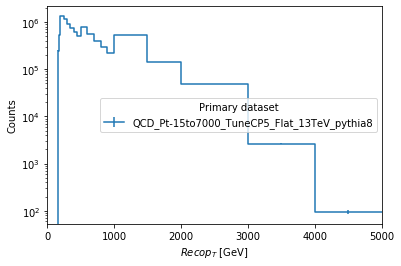

In [5]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False
                    )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

<Hist (m_reco_axis) instance at 0x7f80fc919128>


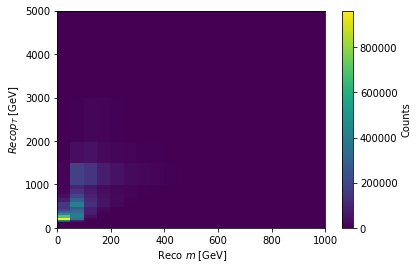

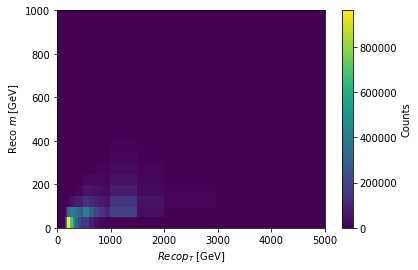

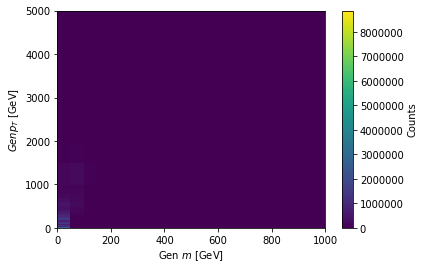

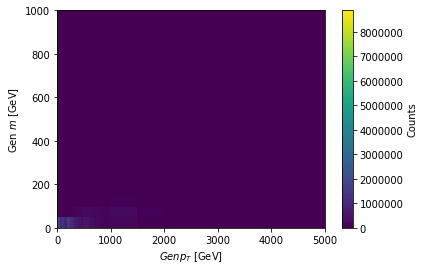

In [6]:
print(output['h_reco_pt_m'].sum('pt_reco_axis', 'dataset'))
hist.plot2d(output['h_reco_pt_m'].sum('dataset'), xaxis='m_reco_axis');
hist.plot2d(output['h_reco_pt_m'].sum('dataset'), xaxis='pt_reco_axis');
hist.plot2d(output['h_gen_pt_m'].sum('dataset'), xaxis='m_gen_axis');
hist.plot2d(output['h_gen_pt_m'].sum('dataset'), xaxis='pt_gen_axis');

<Hist (dataset,pt_gen_axis,pt_reco_axis,m_gen_axis,m_reco_axis) instance at 0x7f80fe0dcbe0>


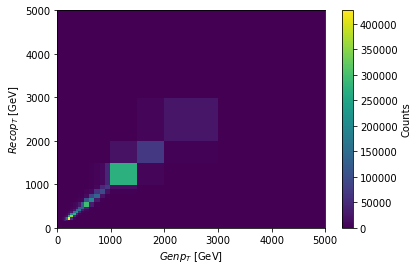

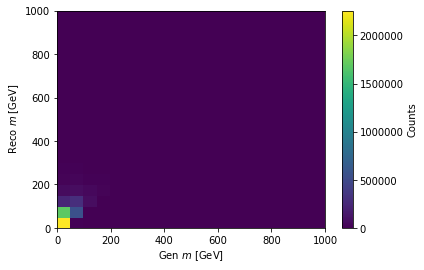

In [7]:
print(output['h_response'])
hist.plot2d(output['h_response'].sum('dataset', 'm_reco_axis', 'm_gen_axis'), xaxis='pt_gen_axis');
hist.plot2d(output['h_response'].sum('dataset', 'pt_reco_axis', 'pt_gen_axis'), xaxis='m_gen_axis');